In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


## load all cells

In [3]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")
cell_metrics = loading.load_all_cell_metrics(df.basepath)


## make psth on ripple for ca1, pfc, and mec

In [4]:
sessions = pd.DataFrame()
sessions["basepath"] = cell_metrics[
    cell_metrics.brainRegion.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")
].basepath.unique()

sessions

,basepath
0,Z:\Data\AYAold\AYA7\day19
1,Z:\Data\AYAold\AYA7\day20
2,Z:\Data\AYAold\AYA7\day24
3,Z:\Data\AYAold\AYA7\day27
4,Z:\Data\AYAold\AYA9\day12
...,...
100,Z:\Data\FujisawaS\EE\EE0622fm
101,Z:\Data\FujisawaS\EE\EE0627fm
102,Z:\Data\FujisawaS\EE\EE0705fm
103,Z:\Data\FujisawaS\EE\EE0706fm


In [5]:
psth_df = pd.DataFrame()
cell_metrics = pd.DataFrame()
for basepath in sessions.basepath:

    st, cell_metric = loading.load_spikes(basepath)
    ripples = loading.load_ripples_events(basepath)
    replays_epochs = nel.EpochArray([np.array([ripples.start, ripples.stop]).T])

    psth = functions.compute_psth(
        st.data, replays_epochs.starts, bin_width=0.01, n_bins=100
    )
    psth_df = pd.concat([psth_df, psth], axis=1, ignore_index=True)
    cell_metrics = pd.concat([cell_metrics, cell_metric], axis=0, ignore_index=True)


## add deep sup

In [6]:
cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)


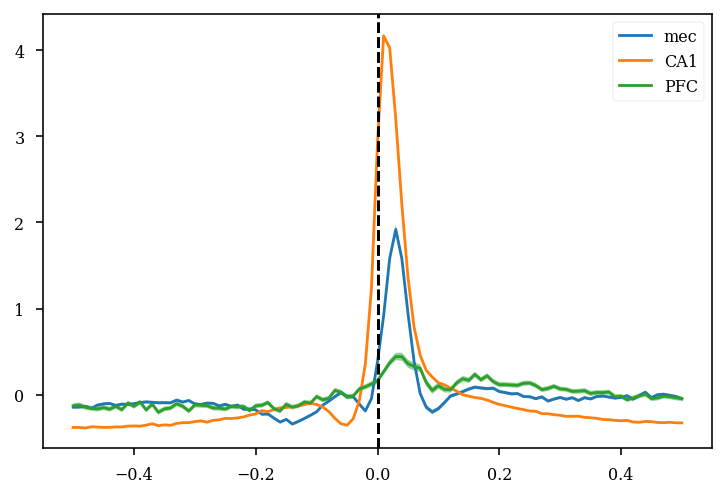

In [7]:
def plot_psth_mean(psth_df,cell_metrics, region_idx, label):


    psth = psth_df.values[:,cell_metrics.brainRegion.str.contains(region_idx).values]

    psth_z = stats.zscore(psth, axis=0)
    plt.plot(psth_df.index, np.nanmean(psth_z, axis=1), label=label)
    plt.fill_between(
        psth_df.index,
        np.nanmean(psth_z, axis=1) - np.nanstd(psth_z, axis=1) / np.sqrt(psth.shape[1]),
        np.nanmean(psth_z, axis=1) + np.nanstd(psth_z, axis=1) / np.sqrt(psth.shape[1]),
        alpha=0.5,
    )
    plt.axvline(x=0, color="k", linestyle="--")
    plt.legend()

plot_psth_mean(psth_df,cell_metrics, "EC1|EC2|EC3|EC4|EC5|MEC", "mec")
plot_psth_mean(psth_df,cell_metrics, "CA1", "CA1")
plot_psth_mean(psth_df,cell_metrics, "PFC", "PFC")

# plt.plot(psth_df.index, psth_df.values[:,cell_metrics.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC").values].mean(axis=1),label="mec")
# plt.plot(psth_df.index, psth_df.values[:,cell_metrics.brainRegion.str.contains("CA1").values].mean(axis=1),label='ca1')
# plt.plot(psth_df.index, psth_df.values[:,cell_metrics.brainRegion.str.contains("PFC").values].mean(axis=1),label='pfc')
# plt.axvline(x=0, color="k", linestyle="--")
plt.legend()
plt.show()

In [ ]:
def plot_psth_matrix(psth_df, cell_metrics, region_idx, label=None, ax=None, vmax=3, vmin=-3):

    psth = psth_df.values[:, cell_metrics.brainRegion.str.contains(region_idx).values]

    sort_idx = np.argsort(np.argmax(psth, axis=0))
    if ax is None:
        plt.figure()
    ax = plt.gca()
    # sns.heatmap(
    #     stats.zscore(psth, axis=0)[:,sort_idx].T,
    #     ax=ax,
    #     cmap="bwr",
    #     vmax=3,
    #     vmin=-3,
    #     xticklabels=False,
    # )
    extent = [psth_df.index.min(), psth_df.index.max(), 0, psth.shape[1]]

    sm = ax.imshow(
        stats.zscore(psth, axis=0)[:, sort_idx].T,
        aspect="auto",
        interpolation="nearest",
        extent=extent,
        vmin=vmin,
        vmax=vmax,
        cmap="bwr"
    )

    ax.set_yticks([psth.shape[1]])

    ax.axvline(0, color="k", lw=1, ls="--")
    if label is not None:
        ax.set_title(label, fontsize=12)
    return sm

plot_psth_matrix(psth_df, cell_metrics, "CA1", "CA1")
plot_psth_matrix(psth_df, cell_metrics, "EC1|EC2|EC3|EC4|EC5|MEC", "mec")
plot_psth_matrix(psth_df, cell_metrics, "PFC", "PFC")



In [ ]:
def confidence_intervals(X,conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X),axis=1) == 0,:]
    # compute interval for each column
    interval = [stats.t.interval(conf, len(a) - 1, loc = np.mean(a), scale = stats.sem(a)) for a in X.T]
    interval = np.vstack(interval)
    lower = interval[:,0]
    upper = interval[:,1]
    return lower,upper
    
def std_upper_lower(X):
    upper = np.nanmean(X,axis=1) + np.nanstd(X,axis=1)
    lower = np.nanmean(X,axis=1) - np.nanstd(X,axis=1)
    return lower,upper

(array([47., 19., 11.,  7., 11.,  4.,  4.,  1.,  2.,  1.]),
 array([1.23302925, 1.57758074, 1.92213223, 2.26668372, 2.61123521,
        2.9557867 , 3.30033819, 3.64488968, 3.98944118, 4.33399267,
        4.67854416]),
 <BarContainer object of 10 artists>)

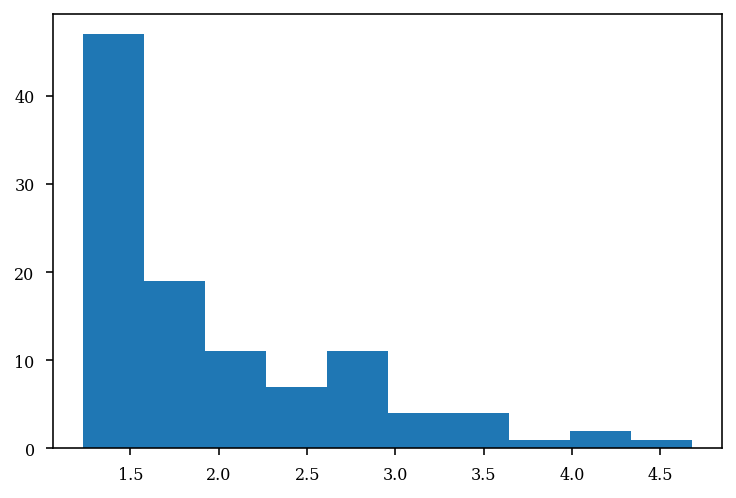

In [19]:
plt.hist(psth.max(axis=0) / psth.mean(axis=0))

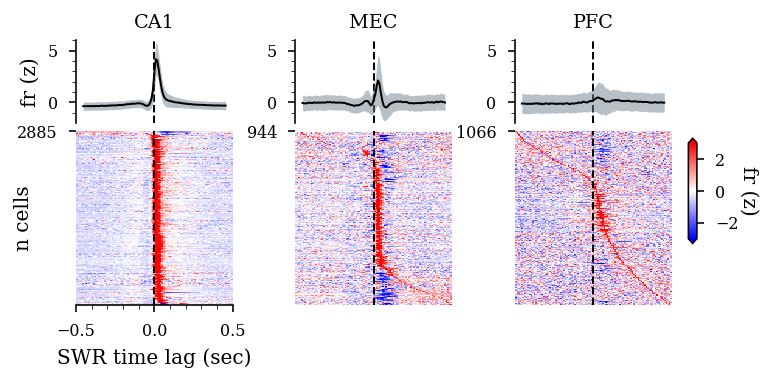

In [83]:
fig = plt.figure(figsize=functions.set_size('thesis', fraction=1, subplots=(2,3)),constrained_layout=False)
gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.4)

y_min = -2
y_max = 6
heatmap_factor = 2

# # mean CI plots
ax0 = fig.add_subplot(gs[0, 0])
psth = psth_df.values[:, cell_metrics.brainRegion.str.contains("CA1").values]
psth = stats.zscore(psth, axis=0)
lower,upper= std_upper_lower(psth)
ax0.plot(psth_df.index,np.nanmean(psth,axis=1),'k',linewidth=1)
ax0.fill_between(psth_df.index, lower, upper, color="slategrey", alpha = .5, linewidth = 0)

ax1 = fig.add_subplot(gs[0, 1])
psth = psth_df.values[:, cell_metrics.brainRegion.str.contains("MEC").values]
psth = stats.zscore(psth, axis=0)

lower,upper= std_upper_lower(psth)
ax1.plot(psth_df.index,np.nanmean(psth,axis=1),'k',linewidth=1)
ax1.fill_between(psth_df.index, lower, upper, color="slategrey", alpha = .5, linewidth = 0)

ax2 = fig.add_subplot(gs[0, 2])
psth = psth_df.values[:, cell_metrics.brainRegion.str.contains("PFC").values]
psth = stats.zscore(psth, axis=0)

lower,upper= std_upper_lower(psth)
ax2.plot(psth_df.index,np.nanmean(psth,axis=1),'k',linewidth=1)
ax2.fill_between(psth_df.index, lower, upper, color="slategrey", alpha = .5, linewidth = 0)

ax3 = fig.add_subplot(gs[1:,0])
plot_psth_matrix(psth_df, cell_metrics,  "CA1", ax=ax3)

ax4 = fig.add_subplot(gs[1:,1])
plot_psth_matrix(psth_df, cell_metrics,  "MEC", ax=ax4)


ax5 = fig.add_subplot(gs[1:,2])
sm = plot_psth_matrix(psth_df, cell_metrics,  "PFC", ax=ax5)

axs = [ax0,ax1,ax2,ax3,ax4,ax5]
for i in range(6):
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

axs = [ax0,ax1,ax2]
for i in range(3):
    axs[i].spines["bottom"].set_visible(False)
    axs[i].axes.get_xaxis().set_ticks([])
    axs[i].axvline(0, linestyle = '--', linewidth = 1, alpha = 1, color = 'k',zorder=-100)

axs = [ax4,ax5]
for i in range(2):
    axs[i].spines["bottom"].set_visible(False)
    axs[i].spines["left"].set_visible(False)
    axs[i].axes.get_xaxis().set_ticks([])
    # axs[i].axes.get_yaxis().set_ticks([])

ax3.spines["left"].set_visible(False)

ax0.set_ylabel('fr (z)')

ax3.set_xlabel('SWR time lag (sec)')
ax3.set_ylabel('n cells',labelpad=-8)

ax0.set_ylim(y_min,y_max)
ax1.set_ylim(y_min,y_max)
ax2.set_ylim(y_min,y_max)

cax = plt.axes([0.77, 0.3, 0.01, 0.3])
cbar = plt.colorbar(sm,cax=cax, extend='both')
cbar.set_label('fr (z)', rotation=270, labelpad=10)

ax0.set_title("CA1")
ax1.set_title("MEC")
ax2.set_title("PFC")

plt.savefig(
    os.path.join(fig_save_path, "psth_ripple_readout.svg"),
    dpi=300,
    bbox_inches="tight",
)